In [1]:
import networkx as nx
import numpy as np
import itertools as it
import random
import pandas as pd
import numpy as np
import math
from typing import Callable

# Brief introduction to the Backbone problem

This part of the problem asks us to connect all the routers together by using a backbone, trying to minimize the number of backbone units placed. This problem, which requires to connect a subset of nodes with a minimum weight tree is actually a famous NP-hard combinatorial problem called [the Steiner tree problem](https://en.wikipedia.org/wiki/Steiner_tree_problem).

After a long study of the existing literature about this problem, the main solutions we found involved the use of approximations which sacrificed the possibility to get the optimal solutions (but allowing at least to have a solution). 
However, our problem instances have a very interesting topology: the building cells can be described with a grid graph with the diagonals, where moving from a cell to one of its neighbours has the same cost. So, the movement from a cell to another can be seen as the movement of a king in a checkboard. This property allows us to compute the distance for each couple of cells in constant time by using the [Chebyshev distance](https://en.wikipedia.org/wiki/Chebyshev_distance).

In this notebook we present our A* heuristic solution to find the Steiner tree (thus, the backbone) of a given routers placement.

## Functions to create a random configuration for the problem

In [2]:
def get_grid_graph(routers_placement: np.array, backbone_unit_cost: int):
    # creating the equivalent grid graph for the routers placement
    n, m = routers_placement.shape
    g = nx.grid_2d_graph(n, m)
    
    # adding edges to the graph
    g.add_edges_from(
        [
            ((x, y), (x + 1, y + 1))
            for x in range(n-1)
            for y in range(m-1)
        ] +
        [
            ((x + 1, y), (x, y + 1))
            for x in range(n-1)
            for y in range(m-1)
        ]
    )
    
    # setting the weight of each edge to the cost of a backbone unit
    for edge in g.edges():
        g.edges()[edge]["weight"] = backbone_unit_cost

    return g

In [3]:
def generate_random_router_configuration(shape, n_routers):
    n, m = shape
    routers_placement = np.zeros(shape)
    routers_coords = set()
    
    while len(routers_coords) != n_routers:
        row = random.randint(0, n-1)
        column = random.randint(0, m-1)
        if routers_placement[row][column] == 0:
            routers_placement[row][column] = 1
            routers_coords.add((row, column))
    
    return routers_placement, list(routers_coords)

In [4]:
def is_valid(g, terminals_coords):
    for (source, target) in it.combinations(terminals_coords, 2):
        if nx.has_path(g, source, target) == False:
            return False
    return True

## Finding Steiner tree by the use of A* search

We exploit the A* search framework in the following way: for each router, we search for the shortest path between the router and the backbone initial starting point. In doing this, we use the Chebyshev distance as heuristic function _h(n)_ and as action cost function _g(n)_ an indicator function which is equal to the cost of a backbone unit if we are following an edge we have never accessed, 0 otherwise. By defining the function _g(n)_ like this we are implicitely guiding the A* search to reuse existing paths we have already found, thus reducing the size of the backbone.

In [5]:
def get_chebyshev_distance(point1: tuple, point2: tuple) -> int:
    x1, y1 = point1
    x2, y2 = point2
    return max(abs(x1 - x2), abs(y1 - y2))

In [6]:
def single_objective_a_star(
    original_g: nx.Graph, 
    routers_coords: list[tuple], 
    backbone_starting_point: tuple, 
    backbone_unit_cost: float
) -> nx.Graph:
    g = nx.Graph(original_g)
    
    # setting the weight of each edge to the cost of a backbone unit
    for edge in g.edges():
        g.edges()[edge]["weight"] = backbone_unit_cost

    # for each router, searching the shortest path
    for router in routers_coords:
        # use a-star to found the shortest past
        path = nx.astar_path(
            g,
            backbone_starting_point,
            router,
            heuristic=get_chebyshev_distance,
            weight="weight"
        )
        # reducing the cost of found edges
        for path_edge in it.pairwise(path):
            g.edges()[path_edge]["weight"] = 0

    # cutting off the edges not used
    edges_to_remove = [edge for edge in g.edges() if g.edges()[edge]["weight"] != 0]
    g.remove_edges_from(edges_to_remove)

    # cutting off nodes with degree zero
    nodes_to_remove = [node for node in g.nodes() if g.degree[node] == 0]
    g.remove_nodes_from(nodes_to_remove)

    return g

## Finding Steiner tree by the use of Kou et al. solution

To understand how good our algorithm is, we compare it with [Kou et al. approximation](https://link.springer.com/article/10.1007/BF00288961) for finding Steiner Trees. There exists newer approximation algorithms, like the one made by [Byrka et al.](https://dl.acm.org/doi/10.1145/1806689.1806769), capable of finding better results than Kou et al; however, for our academic purposes they weren't worth making.

Intuitively, this algorithm realizes the Minimum Spanning Tree (MST) between all the targets and then uses this MST as a "guide" to build the approximation of the Steiner Tree. The main problem of this algorithm is that it needs to compute the shortest paths for each couple of terminals, making its use **unfeasible** for our routers placements; on our machine the native implementation of NetworkX has not been able to compute matrices with more than 196 nodes.

However, we managed to overcome this problem by leveraging the topology of the graph: just like we did above for the A* search, we can use the Chebyshev distance to compute the shortest paths. So, we have reimplemented Kou et al. algorithm using Chebyshev instead of Djkstra, thus making possible to use this approximations even for problem instances that otherwise would have been uncomputable.

In [7]:
def get_complete_distance_graph(
        g_original: nx.Graph,
        terminal_nodes: list[object],
        distance_function: Callable[[object, object], float]
) -> nx.Graph:
    """
    Creates the complete graph of the terminal nodes, using the distance function to compute
    the distance among nodes.

    :param g_original:
    :param terminal_nodes:
    :param distance_function:
    :return:
    """
    g = nx.Graph()

    # adding points nodes
    g.add_nodes_from(terminal_nodes)

    # computing distances among points
    for (p1, p2) in it.combinations(terminal_nodes, 2):
        shortest_path_length = nx.shortest_paths.astar_path_length(g_original, p1, p2, distance_function)
        g.add_edge(p1, p2, weight=shortest_path_length)

    return g


def remove_redundant_nodes(
        g_original: nx.Graph,
        terminal_nodes: list[object]
) -> nx.Graph:
    """
    Prune the Steiner Tree by removing the non-terminal nodes so that all the leaves
    are steiner points

    :param g_original:
    :param terminal_nodes:
    :return: pruned Steiner Tree
    """
    g = nx.Graph(g_original)

    leaf_nodes = [node for node in g.nodes() if g.degree(node) == 1 and node not in terminal_nodes]
    while leaf_nodes != []:
        g.remove_nodes_from(leaf_nodes)
        leaf_nodes = [node for node in g.nodes() if g.degree(node) == 1 and node not in terminal_nodes]
        
    return g


def kou_et_al(
        g_original: nx.Graph,
        distance_function: Callable[[object, object], float],
        terminal_points: list[object],
        weight: str = "weight"
) -> nx.Graph:
    """
    Computes the steiner tree of a graph using the distance function to compute the distances among points

    :param g_original:
    :param distance_function:
    :param terminal_points:
    :param weight:
    :return:
    """
    # costruct the complete undirected distance graph
    g1 = get_complete_distance_graph(g_original, terminal_points, distance_function)

    # find the MST
    g2 = nx.minimum_spanning_tree(g1)

    # use the MST as a guide to construct the subgraph of the original graph
    g3 = nx.Graph()

    # for each edge, search shortest from begin to target and add it to new graph
    for (start_node, end_node) in g2.edges():
        shortest_path = nx.shortest_paths.astar_path(g_original, start_node, end_node, distance_function)

        for (edge_start, edge_end) in it.pairwise(shortest_path):
            g3.add_edge(edge_start, edge_end, weight=g_original[edge_start][edge_end][weight])

    # apply the MST on the sub graph
    g4 = nx.minimum_spanning_tree(g3)

    # construct the steiner tree by pruning the MST of the subgraph
    g5 = remove_redundant_nodes(g4, terminal_points)

    return g5


# Algorithm comparisons

## Solution value comparison

In [8]:
results = []
sizes = list(range(50, 400, 25))
for size in sizes:
    print(f"Current matrix size: ({size},{size})")
    matrix_size = (size, size)
    n_routers = round(size * 0.4)
    backbone_unit_cost = 4
    routers_placement, routers_coords = generate_random_router_configuration(matrix_size, n_routers)
    initial_backbone = routers_coords.pop() # using a random generated point as backbone
    terminal_points = list(it.chain(routers_coords, [initial_backbone]))
    
    # creating graph
    g = get_grid_graph(routers_placement, backbone_unit_cost)
    
    # steiner approx.
    #steiner_tree_kou_g = kou_et_al(g, terminal_points, backbone_unit_cost)
    steiner_tree_kou_g = kou_et_al(g, get_chebyshev_distance, terminal_points, "weight")
    
    # heuristic function
    heuristic_g = single_objective_a_star(g, routers_coords, initial_backbone, backbone_unit_cost)
    
    # computing the tree weights
    heuristic_weight = len(heuristic_g.edges()) * backbone_unit_cost
    approx_weight = len(steiner_tree_kou_g.edges()) * backbone_unit_cost
    
    results.append([heuristic_weight, approx_weight])

Current matrix size: (50,50)
Current matrix size: (75,75)
Current matrix size: (100,100)
Current matrix size: (125,125)
Current matrix size: (150,150)
Current matrix size: (175,175)
Current matrix size: (200,200)
Current matrix size: (225,225)
Current matrix size: (250,250)
Current matrix size: (275,275)
Current matrix size: (300,300)
Current matrix size: (325,325)
Current matrix size: (350,350)
Current matrix size: (375,375)


<AxesSubplot: title={'center': 'Algorithms performance comparison'}, xlabel='Number of nodes', ylabel='Total backbone cost'>

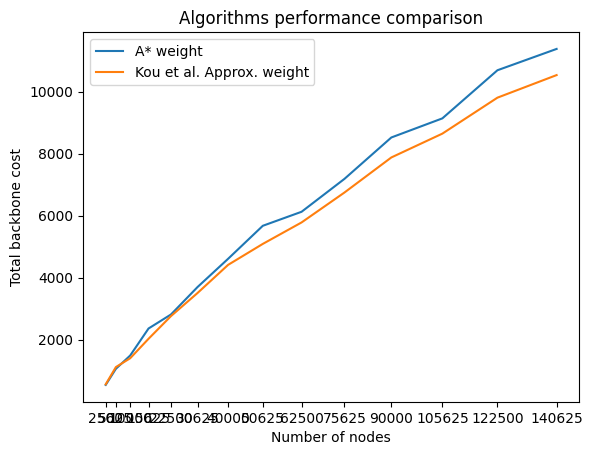

In [9]:
results_df = pd.DataFrame(
    results, 
    columns=["A* weight", "Kou et al. Approx. weight"],
    index = [size**2 for size in sizes]
)
results_df.plot.line(
    title="Algorithms performance comparison",
    xlabel="Number of nodes",
    ylabel="Total backbone cost",
    xticks=[size**2 for size in sizes]
)

## Time comparison

In the following cells, we create a 100x100 matrix with 40 routers to compare the time needed by both the algorithms; the result shows how our A* search take much less time to run.

In [ ]:
size = 100
matrix_size = (size, size)
n_routers = round(size * 0.4)
backbone_unit_cost = 4
routers_placement, routers_coords = generate_random_router_configuration(matrix_size, n_routers)
initial_backbone = routers_coords.pop() # using a random generated point as backbone
terminal_points = list(it.chain(routers_coords, [initial_backbone]))

g = get_grid_graph(routers_placement, backbone_unit_cost)

In [11]:
%%time
_ = steiner_tree_kou_g = kou_et_al(g, get_chebyshev_distance, terminal_points, "weight")

CPU times: user 32.3 s, sys: 36 ms, total: 32.3 s
Wall time: 32.4 s


In [12]:
%%time 
_ = heuristic_g = single_objective_a_star(g, routers_coords, initial_backbone, backbone_unit_cost)

CPU times: user 1.16 s, sys: 12 ms, total: 1.17 s
Wall time: 1.17 s


# Assessing A* solution properties

## Assessing A* stability

### Variance for multiple runs on the same configuration with the same router exploration order

Assessing if there is any variance when the algorithm is perfomed multiple times on the same configuration. Our empirical approach shows how there is no variance for multiple runs on the same configuration, suggesting the determinism of the heuristic.

In [13]:
# creating a set of configurations to test   
n_configurations = 20
n_run_per_configuration = 20

matrix_size = (300,300)
n_routers = 12
backbone_unit_cost = 4

all_results = [] # all run results for each configuration
configurations = ( generate_random_router_configuration(matrix_size, n_routers) for _ in range(n_configurations) )
for (routers_placement, routers_coords) in configurations:
    initial_backbone = routers_coords.pop()
    g = get_grid_graph(routers_placement, backbone_unit_cost) # generating grid graph
    
    # run each configuration 
    configuration_results = []
    for _ in range(n_run_per_configuration):
        # finding steiner tree 
        heuristic_g = single_objective_a_star(g, routers_coords, initial_backbone, backbone_unit_cost)
        # saving the steiner tree weight of this run 
        configuration_results.append(len(heuristic_g.edges())*backbone_unit_cost)
    
    all_results.append(configuration_results)

In [14]:
stability_df = pd.DataFrame(
    np.array(all_results).T, 
    columns = [f"Configuration #{index} runs" for index in range(n_configurations)],
    index = [f"Run #{index} weight" for index in range(n_run_per_configuration)]
)
stability_df.describe()

,Configuration #0 runs,Configuration #1 runs,Configuration #2 runs,Configuration #3 runs,Configuration #4 runs,Configuration #5 runs,Configuration #6 runs,Configuration #7 runs,Configuration #8 runs,Configuration #9 runs,Configuration #10 runs,Configuration #11 runs,Configuration #12 runs,Configuration #13 runs,Configuration #14 runs,Configuration #15 runs,Configuration #16 runs,Configuration #17 runs,Configuration #18 runs,Configuration #19 runs
count,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,2144.0,2116.0,2660.0,2620.0,2656.0,2192.0,2700.0,2512.0,2432.0,2424.0,2604.0,2308.0,2588.0,2524.0,2520.0,2524.0,2740.0,2440.0,2272.0,2868.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,2144.0,2116.0,2660.0,2620.0,2656.0,2192.0,2700.0,2512.0,2432.0,2424.0,2604.0,2308.0,2588.0,2524.0,2520.0,2524.0,2740.0,2440.0,2272.0,2868.0
25%,2144.0,2116.0,2660.0,2620.0,2656.0,2192.0,2700.0,2512.0,2432.0,2424.0,2604.0,2308.0,2588.0,2524.0,2520.0,2524.0,2740.0,2440.0,2272.0,2868.0
50%,2144.0,2116.0,2660.0,2620.0,2656.0,2192.0,2700.0,2512.0,2432.0,2424.0,2604.0,2308.0,2588.0,2524.0,2520.0,2524.0,2740.0,2440.0,2272.0,2868.0
75%,2144.0,2116.0,2660.0,2620.0,2656.0,2192.0,2700.0,2512.0,2432.0,2424.0,2604.0,2308.0,2588.0,2524.0,2520.0,2524.0,2740.0,2440.0,2272.0,2868.0
max,2144.0,2116.0,2660.0,2620.0,2656.0,2192.0,2700.0,2512.0,2432.0,2424.0,2604.0,2308.0,2588.0,2524.0,2520.0,2524.0,2740.0,2440.0,2272.0,2868.0


### Mutiple runs on the same configuration with different routers order

For each configuration try the A* search algorithm with every possible permutation of the routers. The results shows how the final tree weight is actually influenced by the order used to search the routers and the choice of a point as initial starting point!

#### Varying backbone initial starting point, permutation of the remaining routers

In [15]:
# creating a set of configurations to test   
n_configurations = 20

matrix_size = (30,30)
n_routers = 4
backbone_unit_cost = 4
n_permutations_per_configuration = math.factorial(n_routers)

all_results = [] # all permutations result for each configuration
configurations = ( generate_random_router_configuration(matrix_size, n_routers) for _ in range(n_configurations) )
for (routers_placement, routers_coords) in configurations:
    g = get_grid_graph(routers_placement, backbone_unit_cost) # generating grid graph
    
    configuration_results = []
    for permutated_routers_coords in it.permutations(routers_coords):
        permutated_routers_coords = list(permutated_routers_coords)
        initial_backbone = permutated_routers_coords.pop() # here, the backbone varies with each permutation
        
        # finding steiner tree 
        heuristic_g = single_objective_a_star(g, permutated_routers_coords, initial_backbone, backbone_unit_cost)
        # saving the steiner tree weight of this permutation 
        configuration_results.append(len(heuristic_g.edges())*backbone_unit_cost)

    all_results.append(configuration_results)

In [16]:
stability_df = pd.DataFrame(
    np.array(all_results).T, 
    columns = [f"Configuration #{index} runs" for index in range(n_configurations)],
    index = [f"Permutation #{index} weight" for index in range(n_permutations_per_configuration)]
)
stability_df.describe()

,Configuration #0 runs,Configuration #1 runs,Configuration #2 runs,Configuration #3 runs,Configuration #4 runs,Configuration #5 runs,Configuration #6 runs,Configuration #7 runs,Configuration #8 runs,Configuration #9 runs,Configuration #10 runs,Configuration #11 runs,Configuration #12 runs,Configuration #13 runs,Configuration #14 runs,Configuration #15 runs,Configuration #16 runs,Configuration #17 runs,Configuration #18 runs,Configuration #19 runs
count,24.0,24.000000,24.000000,24.0000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.00000,24.000000,24.000000,24.000000,24.000000,24.00000,24.000000,24.000000,24.000000,24.000000
mean,56.0,93.833333,185.000000,137.5000,121.000000,104.000000,119.333333,155.833333,111.833333,133.000000,88.50000,90.666667,137.000000,160.000000,144.166667,138.00000,91.000000,119.666667,134.333333,67.000000
std,0.0,10.281544,5.927093,15.2344,11.810091,8.667781,7.334651,18.329512,17.945974,7.483315,2.44949,8.560103,18.129966,21.845306,13.107139,13.39695,7.101745,7.636677,13.077251,5.808539
min,56.0,84.000000,180.000000,120.0000,112.000000,92.000000,116.000000,140.000000,96.000000,128.000000,84.00000,84.000000,116.000000,136.000000,128.000000,120.00000,84.000000,116.000000,116.000000,60.000000
25%,56.0,88.000000,183.000000,124.0000,112.000000,101.000000,116.000000,140.000000,96.000000,128.000000,88.00000,84.000000,116.000000,136.000000,136.000000,128.00000,84.000000,116.000000,124.000000,60.000000
50%,56.0,88.000000,184.000000,136.0000,116.000000,104.000000,116.000000,144.000000,104.000000,128.000000,88.00000,88.000000,140.000000,160.000000,140.000000,140.00000,90.000000,116.000000,136.000000,68.000000
75%,56.0,100.000000,184.000000,148.0000,129.000000,107.000000,117.000000,177.000000,123.000000,140.000000,89.00000,92.000000,141.000000,166.000000,156.000000,144.00000,93.000000,116.000000,148.000000,69.000000
max,56.0,116.000000,208.000000,164.0000,148.000000,116.000000,144.000000,184.000000,144.000000,148.000000,92.00000,108.000000,168.000000,200.000000,172.000000,160.00000,104.000000,136.000000,148.000000,76.000000


#### Fixed backbone initial starting point, permutation of the remaining routers

In [17]:
# creating a set of configurations to test   
n_configurations = 20

matrix_size = (30,30)
n_routers = 4
backbone_unit_cost = 4
n_permutations_per_configuration = math.factorial(n_routers-1)

all_results = [] # all permutations result for each configuration
configurations = ( generate_random_router_configuration(matrix_size, n_routers) for _ in range(n_configurations) )
for (routers_placement, routers_coords) in configurations:
    g = get_grid_graph(routers_placement, backbone_unit_cost) # generating grid graph
    
    configuration_results = []
    initial_backbone = routers_coords.pop() # here, the backbone is fixed and the targets are permutated
    for permutated_routers_coords in it.permutations(routers_coords):  
        # finding steiner tree 
        heuristic_g = single_objective_a_star(g, permutated_routers_coords, initial_backbone, backbone_unit_cost)
        # saving the steiner tree weight of this permutation 
        configuration_results.append(len(heuristic_g.edges())*backbone_unit_cost)

    all_results.append(configuration_results)

In [18]:
stability_df = pd.DataFrame(
    np.array(all_results).T, 
    columns = [f"Configuration #{index} runs" for index in range(n_configurations)],
    index = [f"Permutation #{index} weight" for index in range(n_permutations_per_configuration)]
)
stability_df

,Configuration #0 runs,Configuration #1 runs,Configuration #2 runs,Configuration #3 runs,Configuration #4 runs,Configuration #5 runs,Configuration #6 runs,Configuration #7 runs,Configuration #8 runs,Configuration #9 runs,Configuration #10 runs,Configuration #11 runs,Configuration #12 runs,Configuration #13 runs,Configuration #14 runs,Configuration #15 runs,Configuration #16 runs,Configuration #17 runs,Configuration #18 runs,Configuration #19 runs
Permutation #0 weight,64,100,116,96,132,120,168,88,68,124,96,100,136,144,80,152,84,120,152,116
Permutation #1 weight,64,100,116,96,132,120,168,96,68,124,96,100,136,144,80,152,88,116,144,116
Permutation #2 weight,76,100,116,100,116,168,156,88,60,128,96,96,152,140,72,152,88,120,152,140
Permutation #3 weight,68,100,144,104,116,168,156,88,56,124,96,100,180,140,80,152,88,116,152,140
Permutation #4 weight,64,100,152,100,132,120,148,96,60,124,96,108,156,164,88,152,96,112,144,140
Permutation #5 weight,68,96,152,100,116,124,148,96,60,124,96,108,156,172,88,152,100,112,144,140


# Final remarks

In this notebook we have compared our heuristic algorithm to one of the most known approximation algorithms to find Steiner trees. We have reached the following conclusions:

* Our heuristic algorithm performs performs slightly worse than Kou et al. approximation algorithm, but it takes an embarrassingly smaller amount of time; however, note that to achieve this result **we had to manually reimplement Kou et al. approximantion algorithm** using the heuristic function (losing the time needed to develop it), otherwise it would not have been possible to get a solution.
* Given a routers configuration, our heuristic algorithm will always give the same solution in a deterministic way;
* Varying the order in which target nodes are reached produces different results with different backbone costs, underlining how **our heuristic algorithm isn't capable of finding the optimal solution**. We aren't able to formulate a strict and formal demonstration of why it happens, but it is possibile to give an intuitive explanation: our method is capable of searching for the shortest path to a target using existing paths, but it's unable to realize that, sacrificing the optimal path to reach the current target might allow to obtain better paths for the targets that have yet to be explored, thus obtaining a better overall solution.